# <center>Web Scraping Brookline Property Listings with Beautiful Soup<center>

___________

I started this project after reading about the concept of Web Scraping on Reddit. I knew HTML from Web Development in college and thought it would be a good way to further my Python skills and do a fun project. The library I'm using is called Beautiful Soup; it allows you to parse through the HTML (website language) of different sites and use that data however you like. 

I decided on the idea of parsing through property listings because I wanted the result to have a useful potential. After Googling "Brookline properties" the first time, I was going to use Zillow.com but their website didn't allow scraping (you can find out if a site does by going to their .com/robots.txt). 

Ultimately, I chose to use https://www.coldwellbankerhomes.com/ma/brookline/ to scrape. It wasn't the easiest to use but the challenge was a good learning opportunity. Once I looked at the page source and got a general idea for the website's HTML, I began to use Beautiful Soup to test grabbing certain elements. 


I'll be breaking this project down into three main parts:

1) Examining the HTML and figuring out how to grab the data 

2) Automating that process for as many pages as Coldwell Banker allows me

3) Doing some exploratory analysis of the resulting dataset

## Exploring the HTML

First, we have to import everything and set up the web scraper:

In [1]:
# Importing libraries
import requests # allows us to send HTTP requests
from bs4 import BeautifulSoup # web scraper
import re # regex which will be used for the third div
import pandas as pd # for dataframe assembly
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

url = 'https://www.coldwellbankerhomes.com/ma/brookline/' # Create a variable with the url
r = requests.get(url) # Use requests to get the contents
html_content = r.text # Get the text of the contents
cb = BeautifulSoup(html_content, 'lxml') # Convert the html content (cb = Coldwell Banker) into a beautiful soup object

Check the title of this webpage:

In [2]:
cb.title.text

'Brookline, MA Homes For Sale & Real Estate'

Perfect, now let's find the HTML we care about. 

#### Grabbing the Divs

HTML is typically broken into "div" sections, as is the case for CB. Each property listing is contained in a parent div that contains a div for the photo on the left and a div for the property info on the right with class "prop-info". We can grab that using the select method in Beautiful Soup.

In [3]:
propinfo = cb.select(".prop-info") # grabbing the class "prop-info" (.prop-info signals it's a class)

In [4]:
# How many properties on the first page?
len(propinfo)

24

In [5]:
# Let's see what the first property's info looks like:
print(propinfo[0].text.strip())

33 Aspinwall Ave 
#4 
Brookline, MA 02446
$749,900


Condo
Active
MLS # 72574611
Updated 17 minutes ago

2Beds
2Full Baths
2Total Baths
1,091Sq. Ft.




HideContactShareMap


This property's HTML is broken down into four divs, each separated above by a space (although "Listed by xyz" is still part of the third div), the last of which contains the "HideContactShareMap" buttons that we won't need. We'll grab the first three to see what they look like, again doing so by selecting the class of their div:

In [6]:
addprice = cb.select(".address-price-etc") # addresses and prices
descrip = cb.select(".description-summary") # just going to get the property type from this one
bbsg = cb.select(".highlights") # beds, baths, sq ft, garage

In [7]:
# Let's make sure we have 24 of these too
print(len(addprice), len(descrip), len(bbsg) )

24 24 24


We now have three lists: "addprice", "descrip" and "bbsg", each containing 24 elements for each of the properties on the first page. Equal list elements contain the respective info for that same property. For instance, the first list element in "addprice" would give you the raw HTML for the address and price of the first property on the page. The first list element in "descrip" gives you the HTML for the first property's second div, and the first list element in "bbsg" gives you the HTML for the first property's third div. 

#### First div: Address and Price

If you simply call the first item in the list, it gives you the raw source code:

In [8]:
# HTML for the first listing
addprice[0]

<div class="address-price-etc"><div class="address notranslate"><a href="/ma/brookline/33-aspinwall-ave-4/pid_32739061/"><div class="street-address-unit"><div class="street-address">33 Aspinwall Ave </div>
<div class="unit-number">#4 </div>
</div><div class="city-st-zip">Brookline, MA 02446</div></a></div><div class="price-block-hpa-other"><div class="price-block"><div class="price">
<div class="price-normal">$749,900</div>
</div></div><div class="hpa-price-other">
</div></div></div>

This div is relatively easy to use because it is broken down into smaller divs that have their own classes, making them grabbable by their class name. For instance, let's print the first five addresses:

In [9]:
addresses = cb.select(".street-address")
for i in range(5):
    print(addresses[i].text.strip())

33 Aspinwall Ave
135 Freeman St
12 White Ave
75 Greenough
705 Hammond St


The fact that there are smaller divs in the first div makes grabbing address and price simply a matter of getting the text for class ".street-address" and ".price" for each element in ".addprice".

#### Second Div: Property Type

The second and third divs are not broken down as cleanly as "addprice" -- they are in the form of lists (annotated by < li >) rather than smaller divs. Lists are difficult to work with in Beautiful Soup because each element doesn't have its own class name like most divs do, making them harder to select especially when the length or order is inconsistent.

In [10]:
descrip[0]

<div class="description-summary"><ul>
<li>Condo</li>
<li>Active</li>
<li>MLS # 72574611</li>
<li class="updated-info">Updated 17 minutes ago</li>
</ul></div>

The only info I was concerned with here was the property type (Condo, Single-Family, etc). Luckily, the property type is always listed as the first element in each property's list. The only way to get this was to find the class of the div encompassing each individual property which is named "#snapshot-" + the number property it is. As you can see below, I then get the name of the second div and "li" which is the unordered list (< ul >) above. Then I grab the first element in that list, and we have our property type.

In [11]:
snapshot = cb.select("#snapshot-" + str(0) + " .description-summary li")
print(snapshot[0].text)

Condo


In the loop, I'll just make the "0" in "str(0)" become "i" so that it changes +1 each time, keeping up with the loop.

#### Third Div: Beds, Baths, Square Feet, Garages

The third div was differently complicated. Its info is in list form, but this time the order and length were inconsistent. Each list element has a class (i.e. class="beds") but Beautiful Soup doesn't let you get the text from a list! Here's what the raw HTML looks like:

In [12]:
bbsg[0]

<ul class="highlights">
<li class="beds"><div class="val">2</div><div class="lbl">Beds</div></li>
<li class="full-baths"><div class="val">2</div><div class="lbl">Full Baths</div></li>
<li class="total-baths"><div class="val">2</div><div class="lbl">Total Baths</div></li>
<li class="sq.-ft."><div class="val">1,091</div><div class="lbl">Sq. Ft.</div></li>
</ul>

The only way I found how to grab the info for beds, baths, garages and square feet was by using something called RegEx (regular expression). Python's built-in pacakage RegEx has a feature that lets you search for the digits before a phrase (done so with the r"(\d+)" below), so I got the text for ".highlights" and searched for the digits before the phrase "Bed", "Total Bath", "Sq", and "Car Garage": 

In [13]:
bbsgtext = bbsg[0].text.strip()
print(bbsgtext)

2Beds
2Full Baths
2Total Baths
1,091Sq. Ft.


In [14]:
bed = re.findall(r"(\d+)Bed", bbsgtext)
print(bed)

['2']


I needed to include exceptions for garages and beds because some properties didn't have info for those two; I made those values zero. Additionally, a small number of properties were listed in acres instead of square feet. I ultimately decided to ignore those listings. 

Now that we've figured out how to grab all the necessary info, it's time to put that info into a loop and iterate over each of the 24 properties.

#### Creating a loop to get the info for each listing:

At the beginning of the code I create seven empty lists for each info type. Once scraped, that info will go into a Pandas DataFrame with each list representing a column. By declaring the lists outside of the loop, we use this code to loop over the next pages' URL since the empty list is created anew each time. 

Here's what the loop for the first page ended up looking like:

In [15]:
staddress = cb.select(".street-address") # address div
prices_ = cb.select(".price") # price div
descrip = cb.select(".description-summary") # property type div
bbsg = cb.select(".highlights") # beds, baths, sq ft, garages div
addresses = []
prices = []
types = []
beds = []
tbaths = []
sqft = []
garages = []
unit = "Unit"
for i in range(24):
        info3_ = bbsg[i].text # getting info for third div
        info3 = info3_.replace(',','') # deleting the ',' in sqft value
        if unit in info3: # ignoring listings that are units
            pass
        else:
            # first div
            addresses.append(staddress[i].text.strip()) # Addresses done
            prices.append(prices_[i].text.strip()) # Prices done
            
            # second div
            snapshot = cb.select("#snapshot-" + str(i) + " .description-summary li")
            types.append(snapshot[0].text) # Property type done
            
            # third div
            bed = re.findall(r"(\d+)Bed", info3)
            if bed:
                pass
            else:
                bed = ['0'] # some listings don't have beds listed
            beds = beds + bed # Beds done
            tbath = re.findall(r"(\d+)Total Bath", info3)
            tbaths = tbaths + tbath # Total baths done
            nft = re.findall(r"(\d+)Sq", info3)
            sqft = sqft + nft # Sqft done
            ngarages = re.findall(r"(\d+)Car Garage", info3)
            if ngarages:
                pass
            else:
                ngarages = ['0'] # some listings don't have garages
            garages = garages + ngarages # Garages done

Now, I put these each info's list into a Pandas DataFrame:

In [16]:
df = pd.DataFrame({'Address': addresses, 
                    'Price': prices, 
                    'Property Type': types, 
                    'Beds': beds, 
                    'Baths': tbaths, 
                    'Square Feet': sqft, 
                    'Garages': garages})
df

,Address,Price,Property Type,Beds,Baths,Square Feet,Garages
0,33 Aspinwall Ave,"$749,900",Condo,2,2,1091,0
1,135 Freeman St,"$800,000",Condo,2,1,1140,0
2,12 White Ave,"$759,000",Condo,3,2,1315,0
3,75 Greenough,"$2,786,000",Condo,4,4,2800,2
4,705 Hammond St,"$1,950,000",Single Family,4,4,2900,2
5,705 Hammond St,"$1,950,000",Townhouse,4,4,2900,2
6,101 Summit Ave,"$995,000",Townhouse,2,3,1405,0
7,955 Hammond St,"$3,050,000",Single Family,4,5,3441,1
8,1755 Beacon St,"$1,899,000",Duplex,4,4,2803,1
9,358 Russett Rd,"$929,000",Single Family,3,3,1930,1


It looks like we may have a duplicate in 705 Hammond St that is listed under both Single Family and Townhouse. We'll leave it for now and take out all such duplicates in the larger dataframe. 

Overall, I like the look of this and am ready to move onto to placing this loop into a master loop that will iterate over each page's URL to get all the listings we possibly can. 

## Iterating over each page's URL

Because we set up the code so nicely to loop over, all we have to do for the master loop is create a formula for each page's URL and add its respective DataFrame to a master DF. The first thing to do is to create this DF outside of the loop so that it doesn't get written over every time the loop iterates over a page. 

In [17]:
listings = pd.DataFrame()

Next, we make a formula for the URL for each page of listings. The URL for each page ends with (page # - 1) * 24, i.e. ends with "48" for page 3, which makes it easy enough to code. We then use the Requests and Beautiful Soup libraries again to get the page source. Once we get the page's class info, we can perform the loop. 

The loop is going to be 6 iterations long because Coldwell Banker only lets us see a certain number of properties for free. At the end of each loop we'll add the resulting lists to a DataFrame and add that DF to our grand DF.

Here's the loop:

In [18]:
for j in range(0,6):
    num = 24*j
    url = 'https://www.coldwellbankerhomes.com/ma/brookline/?sortId=2&offset=' + str(num)

    # Setting up
    r = requests.get(url)
    html_content = r.text
    cb = BeautifulSoup(html_content, 'lxml') 
    
    # Getting HTML
    # First div classes we need for address and price
    staddress = cb.select(".street-address")
    prices_ = cb.select(".price")
    # Second div classes
    proptype = cb.select(".description-summary li")
    # Third div classes
    bbsg = cb.select(".highlights") # beds, baths, sq ft, garage
    
    # Performing the loop
    beds = []
    tbaths = []
    types = []
    addresses = []
    prices = []
    sqft = []
    garages = []
    unit = "Unit"
    for i in range(24):
        info3_ = bbsg[i].text # getting info for third div
        info3 = info3_.replace(',','') # deleting the ',' in sqft value
        if unit in info3: # ignoring listings that are units
            pass
        else:
            # first div
            addresses.append(staddress[i].text.strip())
            prices.append(prices_[i].text.strip()) # Prices done
            # second div
            snapshot = cb.select("#snapshot-" + str(num + i) + " .description-summary li")
            types.append(snapshot[0].text) # getting type
            # third div
            bed = re.findall(r"(\d+)Bed", info3)
            if bed:
                pass
            else:
                bed = ['0']
            beds = beds + bed # Beds done
            tbath = re.findall(r"(\d+)Total Bath", info3)
            tbaths = tbaths + tbath # Total baths done
            nft = re.findall(r"(\d+)Sq", info3)
            sqft = sqft + nft # Sqft done
            ngarages = re.findall(r"(\d+)Car Garage", info3)
            if ngarages:
                pass
            else:
                ngarages = ['0'] # some listings don't have garages
            garages = garages + ngarages # Garages done
    df = pd.DataFrame({'Address': addresses, 
                     'Price': prices, 
                     'Property Type': types, 
                     'Beds': beds, 
                     'Baths': tbaths, 
                     'Square Feet': sqft, 
                     'Garages': garages})
    listings = listings.append(df)

Before displaying the DataFrame we have to check if there are any duplicates by checking for the same address and square footage. The properties that are the same are typically listed as both Townhouse and Single Family.

In [19]:
duplicateRows = listings[(listings["Address"].duplicated()) & (listings["Square Feet"].duplicated())]
duplicateRows

,Address,Price,Property Type,Beds,Baths,Square Feet,Garages
5,705 Hammond St,"$1,950,000",Townhouse,4,4,2900,2
14,38 Gorham Ave,"$2,975,000",Single Family,4,4,3521,2
9,167 Walnut St,"$1,825,000",Townhouse,6,4,3180,1


In [20]:
# dropping rows that are in both duplicateRows and listings
listings = (pd.merge(listings,duplicateRows, indicator=True, how='outer')
         .query('_merge=="left_only"')
         .drop('_merge', axis=1)) 

Let's see the final table:

In [21]:
pd.options.display.max_rows = 999 # so you can see every bloody listing
listings = listings.reset_index(drop=True) # so the first column index is accurate
listings

,Address,Price,Property Type,Beds,Baths,Square Feet,Garages
0,33 Aspinwall Ave,"$749,900",Condo,2,2,1091,0
1,135 Freeman St,"$800,000",Condo,2,1,1140,0
2,12 White Ave,"$759,000",Condo,3,2,1315,0
3,75 Greenough,"$2,786,000",Condo,4,4,2800,2
4,705 Hammond St,"$1,950,000",Single Family,4,4,2900,2
5,101 Summit Ave,"$995,000",Townhouse,2,3,1405,0
6,955 Hammond St,"$3,050,000",Single Family,4,5,3441,1
7,1755 Beacon St,"$1,899,000",Duplex,4,4,2803,1
8,358 Russett Rd,"$929,000",Single Family,3,3,1930,1
9,15 Westbourne Terrace,"$699,900",Condo,2,1,1039,0


That's a lot of properties. I was happy with how the final DataFrame turned out -- if you check any property on there it lines up with its online counterpart. After the challenging process of figuring out how to scrape each individual element from the website, we have our dataset. 

## Exploratory Analysis

I placed less emphasis on this section because this was mostly a web scraping project, but had to make some graphs with the dataset.

Biggest questions:
- Property Type breakdown?
- Histogram of Prices?
- How each variable influences price?

### Graphing Property Types

Let's get a breakdown of the property types:

Text(0, 0.5, '')

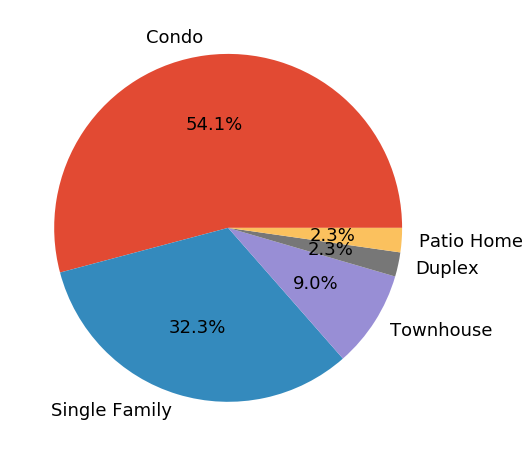

In [22]:
plt.style.use('ggplot')
typecount = listings["Property Type"].value_counts()
typecount.plot(kind="pie",
               # legend = False,
                figsize=(8,8), 
               # colors = ['#66b3ff','#99ff99','#ff9999'], # Get colors that pop
                fontsize = 18, autopct = '%.1f%%', # Round to 1 decimal and include % sign
                )
plt.ylabel('') # Hide the y-label 

Condo is clearly the most common property type, followed by single family. Townhouses, duplexes and patio homes make up the remaining 13.6%. 

##### Property Type vs Price

First, we must take out the dollar signs and commas from the price column:

In [23]:
listings['Price'] = listings['Price'].str.replace('$', '')
listings['Price'] = listings['Price'].str.replace(',', '')
listings["Price"] = listings["Price"].astype(int) # obj -> int

Let's see how each property type stacks up against one another in terms of price. I took out properties over 6 million because they were all single families...

In [24]:
listings.nlargest(11, "Price")

,Address,Price,Property Type,Beds,Baths,Square Feet,Garages
90,112 Woodland Rd,33900000,Single Family,5,7,12112,3
25,14 Allerton St,12888888,Single Family,7,8,7450,2
92,21 Sears Rd,10700000,Single Family,5,7,8498,3
60,197 Cabot,8500000,Single Family,6,8,6720,3
28,45 Leicester St,8200000,Single Family,6,8,9600,3
126,11 Cramond Rd,7895000,Single Family,4,7,6580,3
112,286 Warren St,7750000,Single Family,7,6,7761,3
118,204 Clyde St,7500000,Single Family,6,8,7502,3
125,80 Seaver St,6750000,Single Family,7,9,9030,6
123,156 Ivy St,5595000,Single Family,5,5,6747,3


 ...and it was more difficult to get an idea of the other property types with a $39.5 million property in the plot. 

Text(-17.949999999999996, 0.5, 'Price')

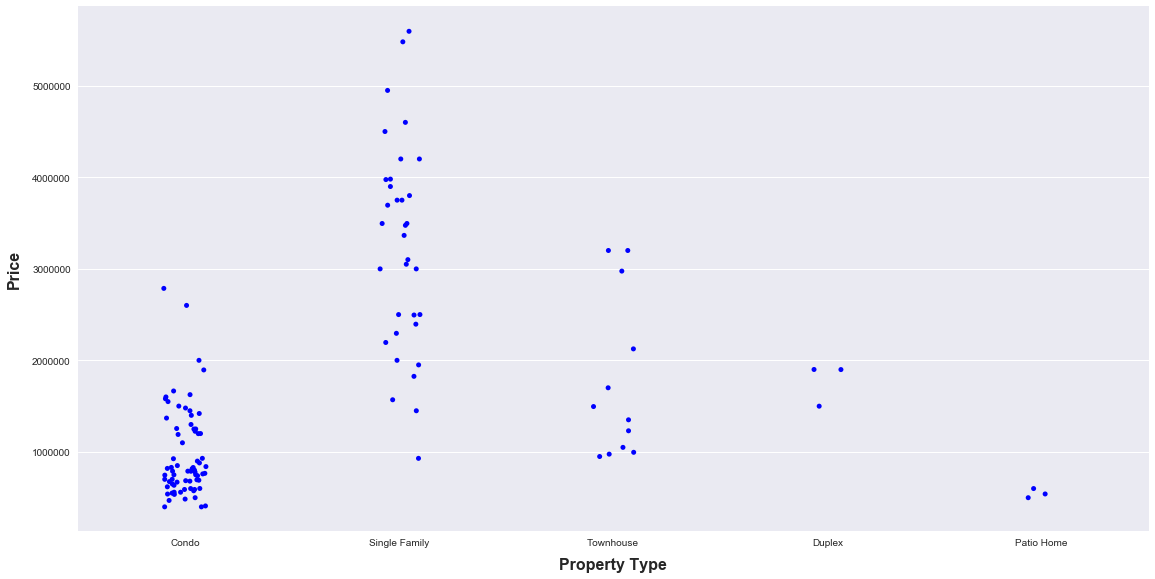

In [25]:
plt.style.use('seaborn')
belowsixmil = listings[listings.Price < 6000000]
sns.catplot('Property Type', 'Price', data = belowsixmil, color = 'b', \
               estimator = np.median, height = 8,  aspect=2)
plt.xlabel("Property Type", size = 16, weight = 'bold', labelpad = 10)
plt.ylabel("Price", size = 16, weight = 'bold', labelpad = 10)

The vast majorities of properties under $1,000,000 are condos. On the other end of the spectrum, the vast majority of expensive properties are single families, unsurprisingly. Patio homes are relatively cheap, while duplexes range a bit pricier, but those sample sizes are extremely small. Overall, this graph just shows how expensive a single family home in Brookline really is. 

### Graphing Prices

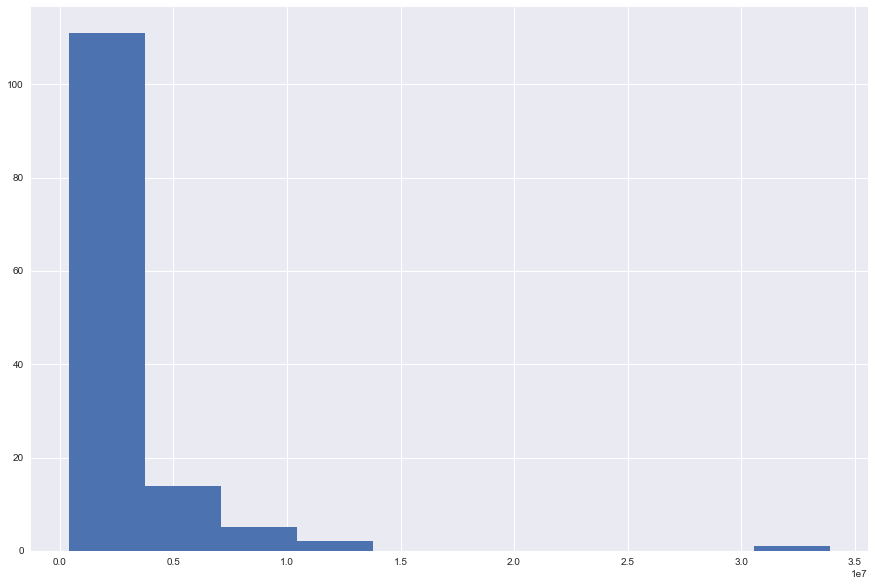

In [26]:
listings.Price.hist(figsize=(15,10))

Pandas wants to do pretty much everything for prices in scientific notation since its values are so large. To avoid having the x axis labeled in terms of e^7, I'm going to create a dataframe "abbvprices" with prices in terms of millions of dollars:

In [27]:
abbvprices = []
ogprices = listings["Price"]
for i in range(len(listings)):
    smaller = ogprices[i]
    abbvprices.append(smaller * .000001)

In [28]:
p = pd.DataFrame({"Abbv. Prices": abbvprices})

I'm going to exclude the 39.5 million dollar property since it is over three times as expensive as the next most expensive home. 

Text(0.5, 1.0, 'Histogram of Brookline Property Prices')

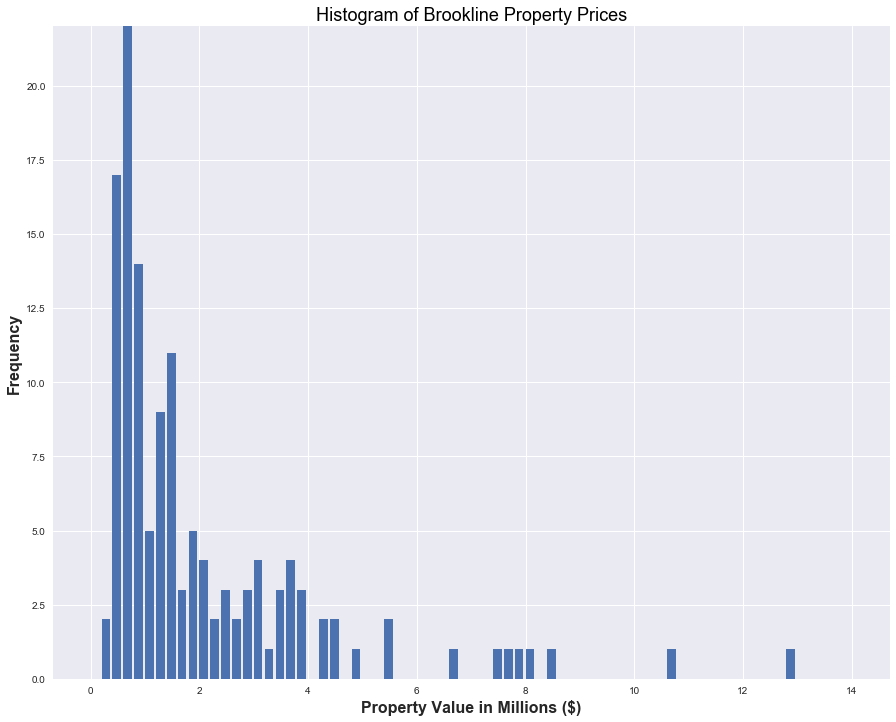

In [29]:
ax = p.plot(kind="hist",
      bins=70,
      range=(0,14),
      legend=False,
      figsize=(15,12),
           width=.16)
ax.set_ylim([0,22])
plt.xlabel("Property Value in Millions ($)", weight='bold', size = 16)
plt.ylabel("Frequency", weight='bold', size=16)
plt.title("Histogram of Brookline Property Prices", color="black", size=18)

Zooming in even more:

Text(0.5, 1.0, 'Histogram of Brookline Property Prices Up to 3 Mil')

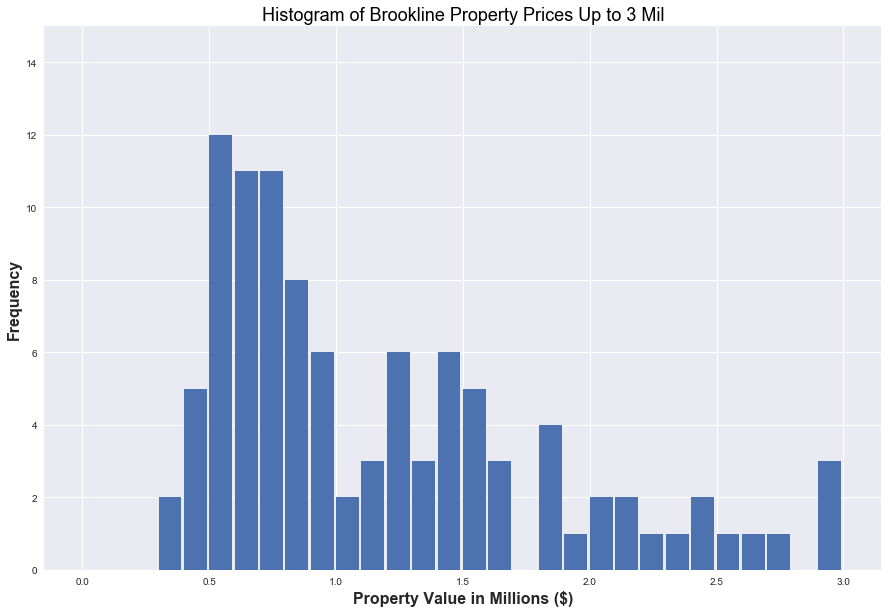

In [30]:
ax = p.plot(kind="hist",
      bins=30,
      range=(0,3),
      legend=False,
      figsize=(15,10),
           width=.09)
ax.set_ylim([0,15])
plt.xlabel("Property Value in Millions ($)", weight='bold', size = 16)
plt.ylabel("Frequency", weight='bold', size=16)
plt.title("Histogram of Brookline Property Prices Up to 3 Mil", color="black", size=18)

The most common price range on the graph is .5-1 million. Let's see how many of the properties are between .5-1 mil:

In [31]:
halftoone = len(listings.loc[((listings.Price<=1000000) & (listings.Price >= 500000))])
halftoone

48

In [32]:
print(f"{(round((halftoone/len(listings))*100, 2))}% of properties are between $500,000 and $1 million.")

36.09% of properties are between $500,000 and $1 million.


### Graphing Sq. ft, Beds, Baths and Garages

Converting numerical columns from obj to int:

In [33]:
listings["Beds"] = listings["Beds"].astype(int)
listings["Baths"] = listings["Baths"].astype(int)
listings["Square Feet"] = listings["Square Feet"].astype(int)
listings["Garages"] = listings["Garages"].astype(int)

Descriptive stats:

In [34]:
lastfourcolumns = listings.drop(columns = ["Address", "Price", "Property Type"]) # getting rid of other columns
lastfourcolumns = lastfourcolumns.astype(int) # obj -> int
lastfourcolumns.describe().round(2) # was originally 6 decimal places

,Beds,Baths,Square Feet,Garages
count,133.00,133.00,133.00,133.00
mean,3.38,3.31,2826.43,1.11
std,1.80,2.16,2375.99,1.13
min,0.00,1.00,375.00,0.00
25%,2.00,2.00,1105.00,0.00
50%,3.00,3.00,1930.00,1.00
75%,5.00,5.00,3521.00,2.00
max,10.00,9.00,12112.00,6.00


##### Square Feet

Text(0.5, 1.0, 'Histogram of Brookline Property Square Feet')

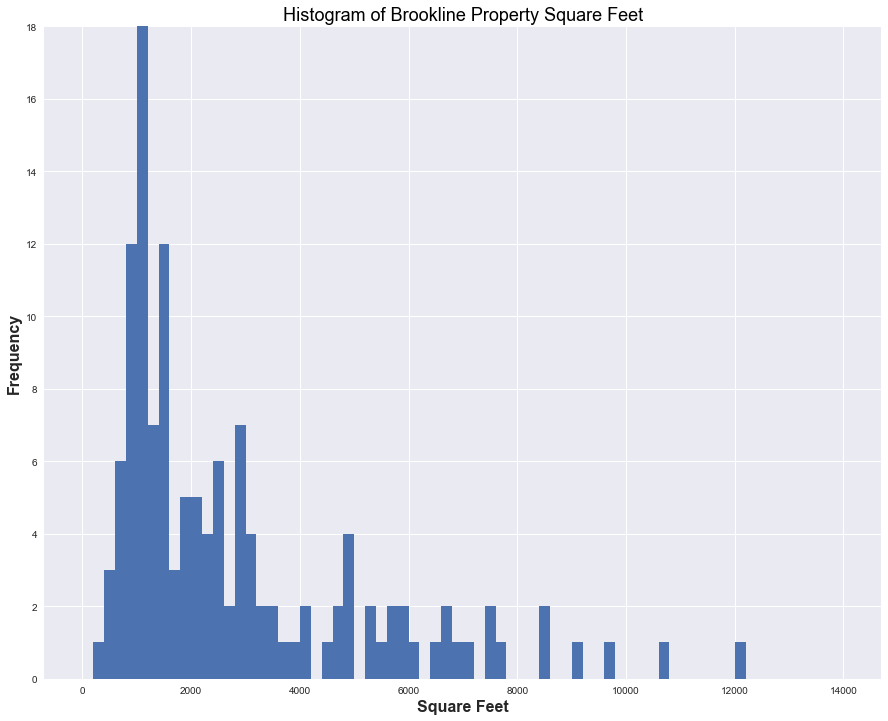

In [35]:
plt.style.use('seaborn')
ax = listings["Square Feet"].hist(bins=70,
                             range=(0,14000),
                            figsize=(15,12))
ax.set_ylim([0,18])
plt.xlabel("Square Feet", weight='bold', size = 16)
plt.ylabel("Frequency", weight='bold', size=16)
plt.title("Histogram of Brookline Property Square Feet", color="black", size=18)

##### Square ft. vs Price

Text(0, 0.5, 'Price ($)')

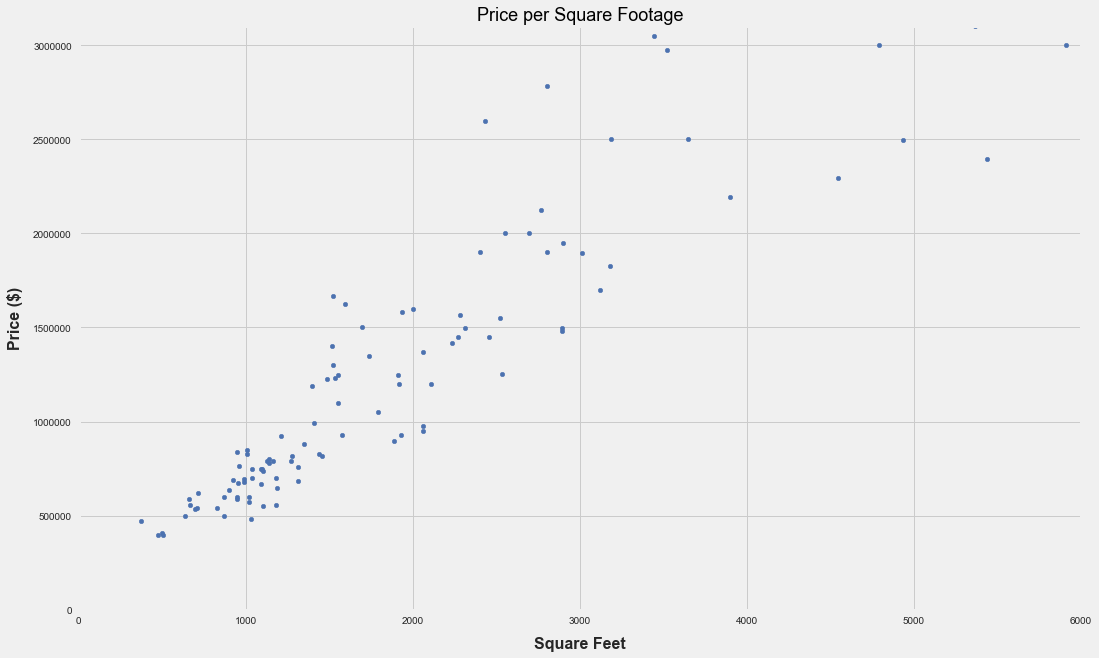

In [36]:
plt.style.use("fivethirtyeight")
listings.plot(kind="scatter",
                x="Square Feet", 
                y="Price",
                figsize=(16,10))
plt.xlim(0, 6000)
plt.ylim(0, 3100000)
plt.title("Price per Square Footage", size=18, color="black")
plt.xlabel("Square Feet", size = 16, weight = 'bold', labelpad = 10)
plt.ylabel("Price ($)", size = 16, weight = 'bold', labelpad = 10)

The biggest outlier here seems like the property in the 2-2.5 mil and 5-6,000 sqft ranges. Let's find out which one that is:

In [37]:
listings.loc[((listings.Price>2000000)&(listings.Price<2500000)&(listings["Square Feet"]>5000)&(listings["Square Feet"]<6000))]

,Address,Price,Property Type,Beds,Baths,Square Feet,Garages
117,612 Newton St,2395000,Single Family,6,6,5436,2


Someone with 2.4 mil should get on that.

##### Beds, Baths, Garages vs Price

Heatmap of Beds vs Baths with Price annotated and color scaled:

In [38]:
sns.set(rc={'figure.figsize':(11,8)})

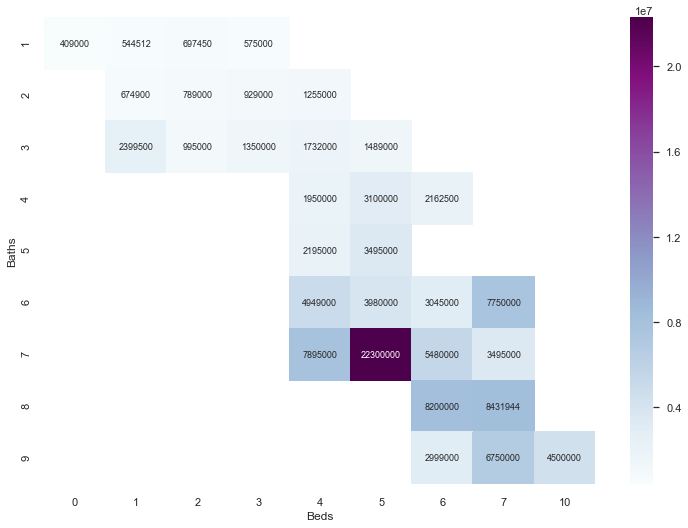

In [40]:
sns.heatmap(listings.groupby([
        'Baths', "Beds"]).Price.median().unstack(),annot=True, annot_kws={"size": 9}, fmt=".0f", cmap="BuPu")
sns.set_style(style='white')

In [41]:
listings.loc[(listings.Beds == 5) & (listings.Baths == 7)]

,Address,Price,Property Type,Beds,Baths,Square Feet,Garages
90,112 Woodland Rd,33900000,Single Family,5,7,12112,3
92,21 Sears Rd,10700000,Single Family,5,7,8498,3


The square with 5 Beds / 7 Baths is indeed the square with the 39.5 million property. 

Narrowing it down a bit:

In [42]:
listings22 = listings.loc[((listings.Baths <= 5) & (listings.Beds <= 5))] # creating the data we want

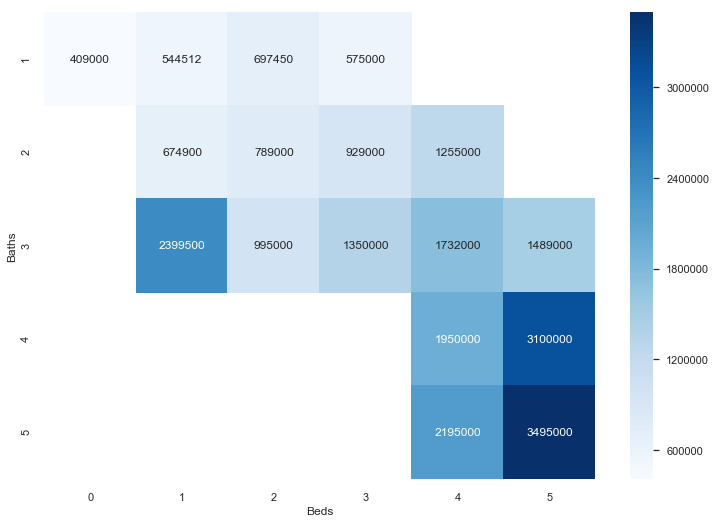

In [43]:
sns.heatmap(listings22.groupby([
        'Baths', "Beds"]).Price.median().unstack(),annot=True, annot_kws={"size": 12}, fmt=".0f", cmap="Blues")
sns.set_style(style='white')

##### Boxplot of Garages

I'm gonna exclude properties over 10 mil to avoid scientific notation and to see the plot better:

In [44]:
listings22 = listings.loc[((listings.Price < 10000000))]

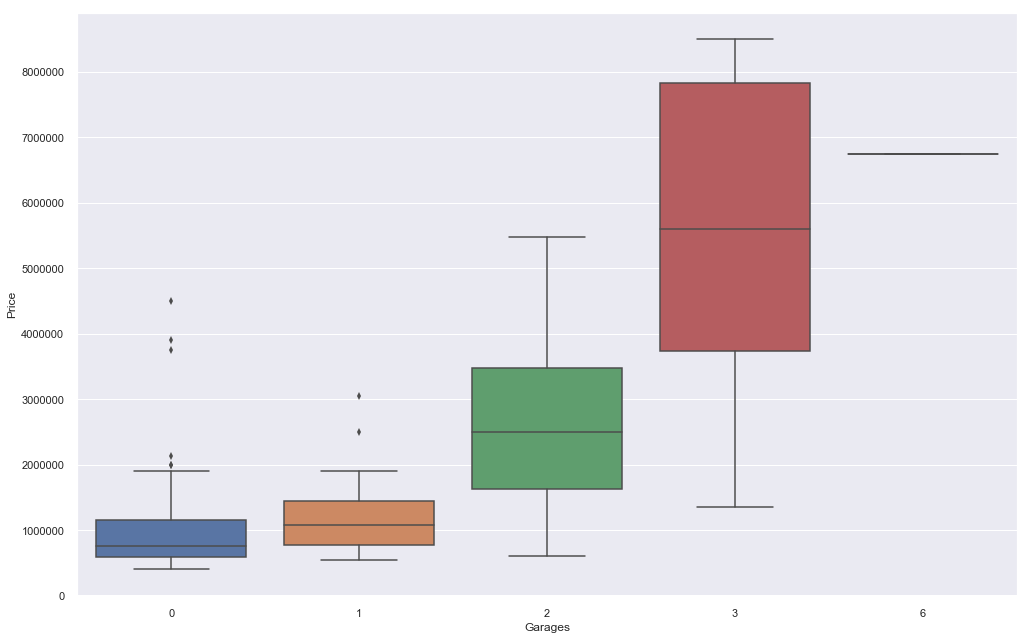

In [45]:
sns.set(rc={'figure.figsize':(15,10)})
sns.boxplot(y='Price', x='Garages', data= listings22)

In [46]:
listings.loc[((listings.Garages == 3))].sort_values(['Price'], ascending=[False])

,Address,Price,Property Type,Beds,Baths,Square Feet,Garages
90,112 Woodland Rd,33900000,Single Family,5,7,12112,3
92,21 Sears Rd,10700000,Single Family,5,7,8498,3
60,197 Cabot,8500000,Single Family,6,8,6720,3
28,45 Leicester St,8200000,Single Family,6,8,9600,3
126,11 Cramond Rd,7895000,Single Family,4,7,6580,3
112,286 Warren St,7750000,Single Family,7,6,7761,3
118,204 Clyde St,7500000,Single Family,6,8,7502,3
123,156 Ivy St,5595000,Single Family,5,5,6747,3
93,60 Sargent Beechwood,4949000,Single Family,4,6,5663,3
100,173 Woodland Rd,3980000,Single Family,5,6,6047,3


The properties with three garages are all pretty pricey. 

##### Boxplots for Beds and Baths

Still excluding properties above 10 mil.

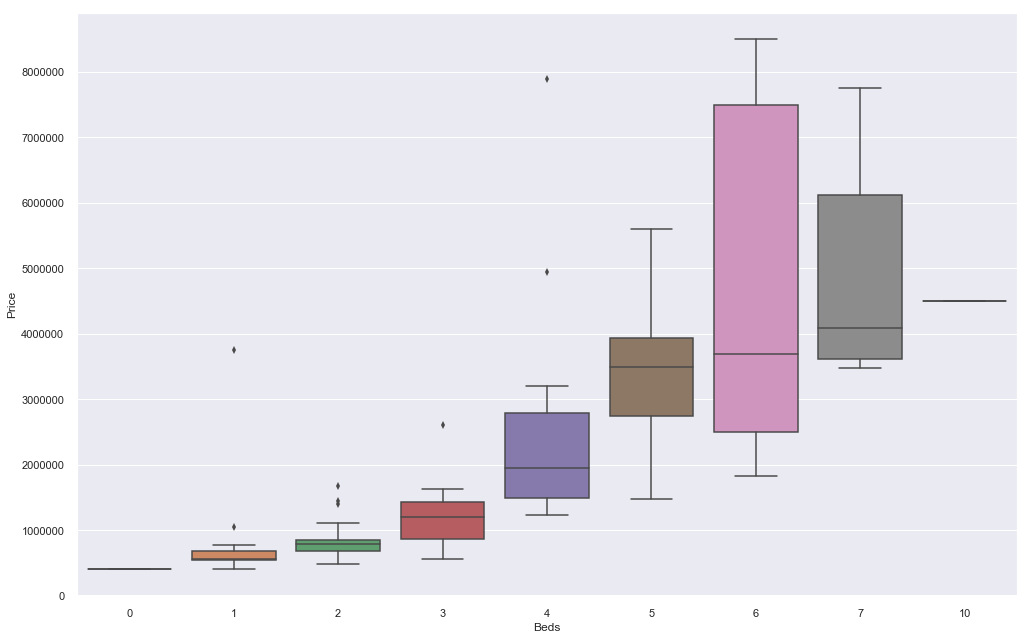

In [47]:
sns.boxplot(y='Price', x='Beds', data=listings22)

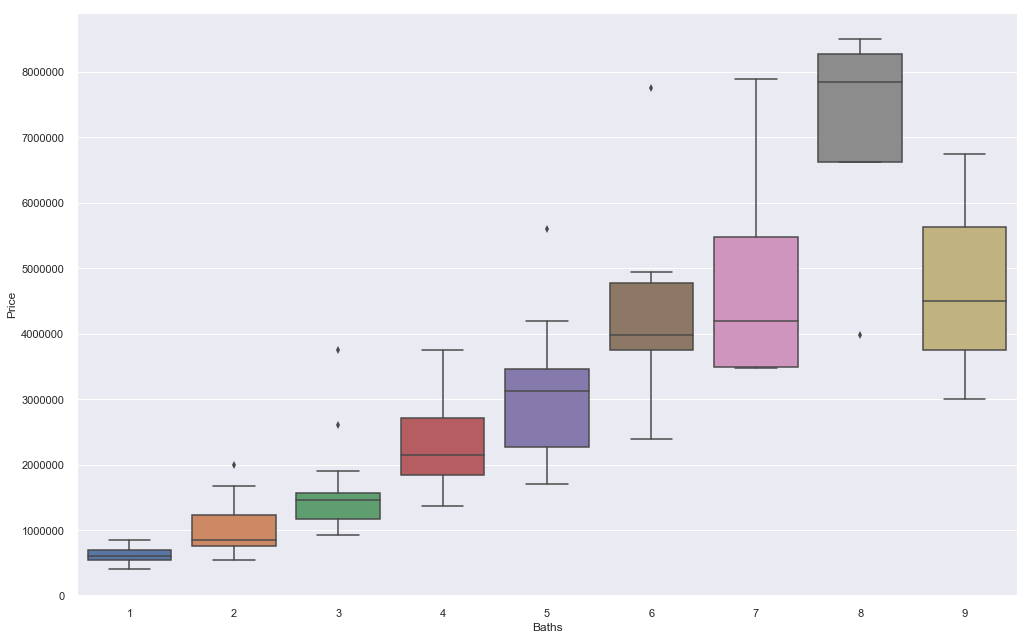

In [48]:
sns.boxplot(y='Price', x='Baths', data=listings22) 

No real surprises here; the median prices rise just about every time. There are definitely some surpising outliers, especially the property that has one bed and is nearly 4 mil. 

## Conclusion

That's my project, thanks a ton for reading if you got this far. I had fun doing this as it was definitely challenging figuring out how to scrape the divs and lists. Beautiful Soup is something that is useful to know so I'm glad I did it. Feel free to use this code for any property listings you want to scrape, just know that it will have to be on Coldwell Banker's site, that is until they change it and this code is useless. 